# Tranfser Learing

## Packages and Subsidiary Functions

In [1]:
!pip install pytorch-lightning
!pip install -q pytorch-metric-learning
!pip install facenet-pytorch
!pip install faiss-gpu
!pip install numpy==1.16.2

  Using cached https://files.pythonhosted.org/packages/63/97/af8a92864a04bfa48f1b5c9b1f8bf2ccb2847f24530026f26dd223de4ca0/numpy-1.19.2-cp36-cp36m-manylinux2010_x86_64.whl
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 2.2.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.16.2
    Uninstalling numpy-1.16.2:
      Successfully uninstalled numpy-1.16.2


  Using cached https://files.pythonhosted.org/packages/35/d5/4f8410ac303e690144f0a0603c4b8fd3b986feb2749c435f7cdbb288f17e/numpy-1.16.2-cp36-cp36m-manylinux1_x86_64.whl
ERROR: umap-learn 0.4.6 has requirement numpy>=1.17, but you'll have numpy 1.16.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 2.2.0 which is incompatible.
ERROR: pytorch-lightning 0.9.0 has requirement numpy>=1.16.4, but you'll have numpy 1.16.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.2
    Uninstalling numpy-1.19.2:
      Successfully uninstalled numpy-1.19.2


In [1]:
import gdown
from google.colab import drive
import os
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, models
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, Resize, RandomHorizontalFlip, RandomErasing
from pytorch_metric_learning import samplers, miners, losses, regularizers
import tensorboard
import pytorch_lightning as pl
import numpy as np
import json
from pytorch_lightning.callbacks import ModelCheckpoint
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
from google.colab import drive
from tqdm import tqdm 
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import time

In [2]:
!nvidia-smi
from psutil import virtual_memory
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(virtual_memory().total / 1e9))

Fri Sep 25 23:48:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    25W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
assert isinstance(device, torch.device)
print('Running on: {}'.format(device))

Running on: cuda


##Class definition of Deep Metric Learing.

In [ ]:
class DeepMetricLearnerA(pl.LightningModule):

    def __init__(self, myclass, net, embedding_size=128, last_layer_size=128, embedding_size_net=128, margin=0.4, batch_size=1024):
        super().__init__()

        self.save_hyperparameters()
        self.embedding_size_net = embedding_size_net
        self.embedding_size = embedding_size
        self.last_layer_size = last_layer_size
        self.batch_size = batch_size
        self.margin = margin
        
        self.net = myclass(net, last_layer_size = self.last_layer_size, embedding_size=self.embedding_size_net)
        self.miner = miners.BatchHardMiner()
        self.loss = losses.TripletMarginLoss(margin=self.margin)

    def forward(self, x):
        return self.net(x.to('cuda')).to('cuda')

    def training_step(self, batch, batch_idx):
        x, labels = batch
        embeddings = self.forward(x)
        triplets = self.miner(embeddings, labels)
        loss = self.loss(embeddings, labels, triplets)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}

    def validation_step(self, batch, batch_idx):
        x, labels = batch
        embeddings = self.forward(x)
        triplets = self.miner(embeddings, labels)
        loss = self.loss(embeddings, labels, triplets)
        return {'val_loss': loss}        

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

    def prepare_data(self):
      self.train_data = train_data
      self.valid_data = valid_data
      examples_per_class = 2
      self.train_sampler = samplers.MPerClassSampler(labels=self.train_data.idx_to_class, m=examples_per_class, length_before_new_iter=len(self.train_data))
      self.valid_sampler = samplers.MPerClassSampler(labels=self.valid_data.idx_to_class, m=examples_per_class, length_before_new_iter=len(self.valid_data))

    def test_step(self, test_batch, batch_idx):
      pass
    
    def test_epoch_end(self, outputs):
      test_acc_mean = 0
      for output in outputs:
        test_acc_mean += output['acc']

      test_acc_mean /= len(outputs)
      tqdm_dict = {'test_acc': test_acc_mean.item()}

        # show test_loss and test_acc in progress bar but only log test_loss
      results = {
            'progress_bar': tqdm_dict,
            'log': {'test_acc': test_acc_mean.item()}
        }
      return results


    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, sampler=self.train_sampler)

    def val_dataloader(self):
        return DataLoader(self.valid_data, batch_size=self.batch_size, sampler=self.valid_sampler)
    
    def test_dataloader(self):
        pass

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=1e-4)
        return optimizer


early_stop_callback = pl.callbacks.early_stopping.EarlyStopping(
   monitor='val_loss',
   min_delta=0.0,
   patience=2,
   verbose=False,
   mode='min'
)

In [ ]:
class DeepMetricLearnerB(pl.LightningModule):

    def __init__(self, myclass, net, embedding_size=128, last_layer_size=128, embedding_size_net=128, margin=0.4, batch_size=128):
        super().__init__()

        self.save_hyperparameters()
        self.embedding_size_net = embedding_size_net
        self.embedding_size = embedding_size
        self.last_layer_size = last_layer_size
        self.batch_size = batch_size
        self.margin = margin
        

        self.net = myclass(net, last_layer_size = self.last_layer_size, embedding_size=self.embedding_size_net)
        self.distance = distances.CosineSimilarity()#b
        self.reducer = reducers.ThresholdReducer(low = 0)#b
        self.miner =  miners.TripletMarginMiner(margin = 0.2, distance = self.distance, type_of_triplets = "semihard") #b
        self.loss = losses.TripletMarginLoss(margin=self.margin, distance = self.distance, reducer = self.reducer) #b
    
  

    def forward(self, x):
        return self.net(x.to('cuda')).to('cuda')

    def training_step(self, batch, batch_idx):
        x, labels = batch
        embeddings = self.forward(x)
        triplets = self.miner(embeddings, labels)
        loss = self.loss(embeddings, labels, triplets)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}

    def validation_step(self, batch, batch_idx):
        x, labels = batch
        embeddings = self.forward(x)
        triplets = self.miner(embeddings, labels)
        loss = self.loss(embeddings, labels, triplets)
        return {'val_loss': loss}        

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

    def prepare_data(self):
      self.train_data = train_data
      self.valid_data = valid_data
      examples_per_class = 2
      self.train_sampler = samplers.MPerClassSampler(labels=self.train_data.idx_to_class, m=examples_per_class, length_before_new_iter=len(self.train_data))
      self.valid_sampler = samplers.MPerClassSampler(labels=self.valid_data.idx_to_class, m=examples_per_class, length_before_new_iter=len(self.valid_data))

    def test_step(self, test_batch, batch_idx):
      pass
    
    def test_epoch_end(self, outputs):
      test_acc_mean = 0
      for output in outputs:
        test_acc_mean += output['acc']

      test_acc_mean /= len(outputs)
      tqdm_dict = {'test_acc': test_acc_mean.item()}

        # show test_loss and test_acc in progress bar but only log test_loss
      results = {
            'progress_bar': tqdm_dict,
            'log': {'test_acc': test_acc_mean.item()}
        }
      return results


    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, sampler=self.train_sampler)

    def val_dataloader(self):
        return DataLoader(self.valid_data, batch_size=self.batch_size, sampler=self.valid_sampler)
    
    def test_dataloader(self):
        pass

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=1e-4)
        return optimizer


early_stop_callback = pl.callbacks.early_stopping.EarlyStopping(
   monitor='val_loss',
   min_delta=0.0,
   patience=2,
   verbose=False,
   mode='min'
)

In [4]:
class DeepMetricLearnerC(pl.LightningModule):

    def __init__(self, myclass, net, embedding_size=128, last_layer_size=128, embedding_size_net=128, margin=0.4, batch_size=1024):
        super().__init__()

        self.save_hyperparameters()
        self.embedding_size_net = embedding_size_net
        self.embedding_size = embedding_size
        self.last_layer_size = last_layer_size
        self.batch_size = batch_size
        self.margin = margin
        
        self.net = myclass(net, last_layer_size = self.last_layer_size, embedding_size=self.embedding_size_net)
        self.miner = miners.BatchHardMiner()
        self.loss = losses.GeneralizedLiftedStructureLoss(neg_margin=1, pos_margin=0)#

    def forward(self, x):
        return self.net(x.to('cuda')).to('cuda')

    def training_step(self, batch, batch_idx):
        x, labels = batch
        embeddings = self.forward(x)
        triplets = self.miner(embeddings, labels)
        loss = self.loss(embeddings, labels, triplets)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}

    def validation_step(self, batch, batch_idx):
        x, labels = batch
        embeddings = self.forward(x)
        triplets = self.miner(embeddings, labels)
        loss = self.loss(embeddings, labels, triplets)
        return {'val_loss': loss}        

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

    def prepare_data(self):
      self.train_data = train_data
      self.valid_data = valid_data
      examples_per_class = 2
      self.train_sampler = samplers.MPerClassSampler(labels=self.train_data.idx_to_class, m=examples_per_class, length_before_new_iter=len(self.train_data))
      self.valid_sampler = samplers.MPerClassSampler(labels=self.valid_data.idx_to_class, m=examples_per_class, length_before_new_iter=len(self.valid_data))

    def test_step(self, test_batch, batch_idx):
      pass
    
    def test_epoch_end(self, outputs):
      test_acc_mean = 0
      for output in outputs:
        test_acc_mean += output['acc']

      test_acc_mean /= len(outputs)
      tqdm_dict = {'test_acc': test_acc_mean.item()}

        # show test_loss and test_acc in progress bar but only log test_loss
      results = {
            'progress_bar': tqdm_dict,
            'log': {'test_acc': test_acc_mean.item()}
        }
      return results


    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, sampler=self.train_sampler)

    def val_dataloader(self):
        return DataLoader(self.valid_data, batch_size=self.batch_size, sampler=self.valid_sampler)
    
    def test_dataloader(self):
        pass

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=1e-4)
        return optimizer


early_stop_callback = pl.callbacks.early_stopping.EarlyStopping(
   monitor='val_loss',
   min_delta=0.0,
   patience=2,
   verbose=False,
   mode='min'
)

In [5]:
class DeepMetricLearnerF(pl.LightningModule):

    def __init__(self, myclass, net, embedding_size=128, last_layer_size=128, embedding_size_net=128, margin=0.4, batch_size=1024):
        super().__init__()

        self.save_hyperparameters()
        self.embedding_size_net = embedding_size_net
        self.embedding_size = embedding_size
        self.last_layer_size = last_layer_size
        self.batch_size = batch_size
        self.margin = margin
        
        self.net = myclass(net, last_layer_size = self.last_layer_size, embedding_size=self.embedding_size_net)
        self.miner = miners.BatchHardMiner()
        self.loss = losses.ContrastiveLoss(pos_margin=0, neg_margin=1)#losses.GeneralizedLiftedStructureLoss(neg_margin=1, pos_margin=0)#

    def forward(self, x):
        return self.net(x.to('cuda')).to('cuda')

    def training_step(self, batch, batch_idx):
        x, labels = batch
        embeddings = self.forward(x)
        triplets = self.miner(embeddings, labels)
        loss = self.loss(embeddings, labels, triplets)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}

    def validation_step(self, batch, batch_idx):
        x, labels = batch
        embeddings = self.forward(x)
        triplets = self.miner(embeddings, labels)
        loss = self.loss(embeddings, labels, triplets)
        return {'val_loss': loss}        

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

    def prepare_data(self):
      self.train_data = train_data
      self.valid_data = valid_data
      examples_per_class = 2
      self.train_sampler = samplers.MPerClassSampler(labels=self.train_data.idx_to_class, m=examples_per_class, length_before_new_iter=len(self.train_data))
      self.valid_sampler = samplers.MPerClassSampler(labels=self.valid_data.idx_to_class, m=examples_per_class, length_before_new_iter=len(self.valid_data))

    def test_step(self, test_batch, batch_idx):
      pass
    
    def test_epoch_end(self, outputs):
      test_acc_mean = 0
      for output in outputs:
        test_acc_mean += output['acc']

      test_acc_mean /= len(outputs)
      tqdm_dict = {'test_acc': test_acc_mean.item()}

        # show test_loss and test_acc in progress bar but only log test_loss
      results = {
            'progress_bar': tqdm_dict,
            'log': {'test_acc': test_acc_mean.item()}
        }
      return results


    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, sampler=self.train_sampler)

    def val_dataloader(self):
        return DataLoader(self.valid_data, batch_size=self.batch_size, sampler=self.valid_sampler)
    
    def test_dataloader(self):
        pass

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=1e-4)
        return optimizer


early_stop_callback = pl.callbacks.early_stopping.EarlyStopping(
   monitor='val_loss',
   min_delta=0.0,
   patience=2,
   verbose=False,
   mode='min'
)

In [6]:
def set_checkpoint_callback(filepath:str, save_top_k:int, net_name:str):
  
  checkpoint_callback = ModelCheckpoint(
      filepath=os.path.join(filepath,''),
      save_top_k=save_top_k,
      verbose=True,
      monitor='val_loss',
      mode='min',
      prefix=net_name
  )
  return checkpoint_callback

Functions definitions for evaluation metrices.

In [7]:
def collate_fn(x):
    return x[0]

##Evaluate function

In [8]:
import numpy as np
from sklearn.model_selection import KFold

def evaluate(distances, labels,  dists, thresholds_roc_start = 0.1,thresholds_roc_end =1.5,thresholds_roc_step = 0.1, diagonal_excl=True):
    # Calculate evaluation metrics
    thresholds = np.arange(thresholds_roc_start ,thresholds_roc_end ,thresholds_roc_step)
    tpr, fpr, accuracy, best_threshold_index = calculate_roc(thresholds, distances,labels, dists, diagonal_excl)
    plot_roc(fpr, tpr, figure_name="roc.png")
    print('the best accuracy:',  accuracy[best_threshold_index]  ,'True Positive rate:',  tpr[best_threshold_index] ,'False Positive rate:', fpr[best_threshold_index],'threshold:',thresholds[best_threshold_index])
   

def calculate_roc(thresholds, distances, labels, dists, diagonal_excl): 
    nrof_pairs = min(len(labels), len(distances))
    nrof_thresholds = len(thresholds)
    
    tprs = np.zeros((nrof_thresholds))
    fprs = np.zeros((nrof_thresholds))
    
    
    acc = np.zeros((nrof_thresholds))

    for threshold_idx, threshold in enumerate(thresholds):
       tprs[threshold_idx], fprs[threshold_idx], acc[threshold_idx] = calculate_accuracy(threshold, distances, dists, labels,diagonal_excl)
    best_threshold_index = np.argmax(acc)

    return tprs, fprs, acc , best_threshold_index

def calculate_accuracy(threshold, dist, dists, actual_issame, diagonal_excl):
    predict_issame = np.less(dist, threshold)
    if diagonal_excl==True:
      tp = np.sum(np.logical_and(predict_issame, actual_issame))-len(dists)
    else: 
      tp = np.sum(np.logical_and(predict_issame, actual_issame))
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    tpr = 0 if (tp + fn == 0) else float(tp) / float(tp + fn)
    fpr = 0 if (fp + tn == 0) else float(fp) / float(fp + tn)
    if diagonal_excl==True:
      acc = float(tp + tn) / (dist.size-len(dists))
    else:  acc = float(tp + tn) / dist.size
    return tpr, fpr, acc


def plot_roc(fpr, tpr, figure_name="roc.png"):
    import matplotlib.pyplot as plt
    plt.switch_backend('Agg')

    from sklearn.metrics import auc
    roc_auc = auc(fpr, tpr)
    fig = plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='#16a085',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='#2c3e50', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right", frameon=False)
    fig.savefig(figure_name, dpi=fig.dpi)

In [9]:
def calculate_accuracy_s(threshold, dist, dists, actual_issame): # accuracy - delete dist=0
    predict_issame = np.less(dist, threshold)
    tp = np.sum(np.logical_and(predict_issame, actual_issame))-len(dists)#hd
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    tpr = 0 if (tp + fn == 0) else float(tp) / float(tp + fn)
    fpr = 0 if (fp + tn == 0) else float(fp) / float(fp + tn)
    acc = float(tp + tn) / ((len(dist)*len(dist[0]))-len(dists)) #acc = float(tp + tn) / dist.size
    return tp,fp,tn,fn,tpr, fpr, acc

In [ ]:
# def tensor_to_image(x):

#   transform = Compose([Normalize([0., 0., 0.], [1/0.229, 1/0.224, 1/0.225]),
#                        Normalize([-0.485, -0.456, -0.406], std = [1.,1.,1.]),
#                        ToPILImage()])
#   image = transform(x.cpu())
#   return image

Function for displaying a tensor as an image.


In [10]:
def display_tensor(x, title=None):
   image = tensor_to_image(x)
   plt.imshow(image)
   if title is not None:
      plt.title('ID osoby: {}'.format(title))

## Datasets downloading and praparation for models training

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### VGGFace2 sample data for MobileFaceNet model training

In [ ]:
%cp '/content/gdrive/My Drive/VGG_mobile_aligned/train_1_aligned_mobile.zip' '/content'
%cp '/content/gdrive/My Drive/VGG_mobile_aligned/train_2_aligned_mobile.zip' '/content'
%cp '/content/gdrive/My Drive/VGG_mobile_aligned/train_3_aligned_mobile.zip' '/content'
%cp '/content/gdrive/My Drive/VGG_mobile_aligned/train_4_aligned_mobile.zip' '/content'
%cp '/content/gdrive/My Drive/VGG_mobile_aligned/train_5_aligned_mobile.zip' '/content'

In [ ]:
!unzip train_1_aligned_mobile.zip
!unzip train_2_aligned_mobile.zip
!unzip train_3_aligned_mobile.zip
!unzip train_4_aligned_mobile.zip
!unzip train_5_aligned_mobile.zip

!rm train_1_aligned_mobile.zip
!rm train_2_aligned_mobile.zip
!rm train_3_aligned_mobile.zip
!rm train_4_aligned_mobile.zip
!rm train_5_aligned_mobile.zip

Streaming output truncated to the last 5000 lines.
  inflating: content/train_5_aligned/n002461/0263_01.jpg  
  inflating: content/train_5_aligned/n002461/0082_01.jpg  
  inflating: content/train_5_aligned/n002461/0372_01.jpg  
  inflating: content/train_5_aligned/n002461/0134_01.jpg  
  inflating: content/train_5_aligned/n002461/0242_01.jpg  
  inflating: content/train_5_aligned/n002461/0119_01.jpg  
  inflating: content/train_5_aligned/n002461/0088_01.jpg  
  inflating: content/train_5_aligned/n002461/0198_01.jpg  
  inflating: content/train_5_aligned/n002461/0282_01.jpg  
  inflating: content/train_5_aligned/n002461/0289_01.jpg  
  inflating: content/train_5_aligned/n002461/0083_01.jpg  
  inflating: content/train_5_aligned/n002461/0231_01.jpg  
  inflating: content/train_5_aligned/n002461/0208_03.jpg  
  inflating: content/train_5_aligned/n002461/0317_01.jpg  
  inflating: content/train_5_aligned/n002461/0125_01.jpg  
  inflating: content/train_5_aligned/n002461/0240_01.jpg  
  inf

In [ ]:
!mkdir '/content/vgg2_train'
!mkdir '/content/vgg2_test'

%cp -r /content/content/train_1_aligned/* '/content/vgg2_train'
%cp -r /content/content/train_2_aligned/* '/content/vgg2_train'
%cp -r /content/content/train_3_aligned/* '/content/vgg2_train'
%cp -r /content/content/train_4_aligned/* '/content/vgg2_train'

%cp -r /content/content/train_5_aligned/* '/content/vgg2_test'

### Personal Photos

In [ ]:
url = 'https://drive.google.com/uc?export=download&id=1zmRmId5xFU4MRrDZ9j5EgYv5bhFlv1nM'
output = 'faces_folder.zip'
gdown.download(url, output, False)
!unzip -o faces_folder.zip
!rm faces_folder.zip

Downloading...
From: https://drive.google.com/uc?export=download&id=1zmRmId5xFU4MRrDZ9j5EgYv5bhFlv1nM
To: /content/faces_folder.zip
124MB [00:00, 250MB/s] 


Archive:  faces_folder.zip
   creating: Faces_Folder/
   creating: Faces_Folder/DD/
  inflating: Faces_Folder/DD/DD_100_143.jpg  
  inflating: Faces_Folder/DD/DD_100_4850.jpg  
  inflating: Faces_Folder/DD/DD_100_600.jpg  
  inflating: Faces_Folder/DD/DD_100_7510.jpg  
  inflating: Faces_Folder/DD/DD_100_4711.jpg  
  inflating: Faces_Folder/DD/DD_100_1410.jpg  
  inflating: Faces_Folder/DD/DD_100_6550.jpg  
  inflating: Faces_Folder/DD/DD_100_6050.jpg  
  inflating: Faces_Folder/DD/DD_100_1371.jpg  
  inflating: Faces_Folder/DD/DD_100_6570.jpg  
  inflating: Faces_Folder/DD/DD_100_5170.jpg  
  inflating: Faces_Folder/DD/DD_100_1841.jpg  
  inflating: Faces_Folder/DD/DD_100_7250.jpg  
  inflating: Faces_Folder/DD/DD_100_2720.jpg  
  inflating: Faces_Folder/DD/DD_100_3050.jpg  
  inflating: Faces_Folder/DD/DD_100_6590.jpg  
  inflating: Faces_Folder/DD/DD_100_7550.jpg  
  inflating: Faces_Folder/DD/DD_100_4360.jpg  
  inflating: Faces_Folder/DD/DD_100_8900.jpg  
  inflating: Faces_Folder

### LFW

In [ ]:
url = 'https://drive.google.com/uc?id=1vfjmbep7UtbY76j81T0jcF4ePbTw-oMY'
output = 'lfw.tgz'
gdown.download(url, output, False)

Downloading...
From: https://drive.google.com/uc?id=1vfjmbep7UtbY76j81T0jcF4ePbTw-oMY
To: /content/lfw.tgz
181MB [00:09, 19.3MB/s]


'lfw.tgz'

In [ ]:
import tarfile
tar = tarfile.open('lfw.tgz')
tar.extractall()
tar.close()

## Models

### MobileFaceNet-A

Downloading needed repositories.

In [ ]:
!git clone https://github.com/TreB1eN/InsightFace_Pytorch.git

fatal: destination path 'InsightFace_Pytorch' already exists and is not an empty directory.


Model downlading.

In [ ]:
%cd '/content/InsightFace_Pytorch'
from model import MobileFaceNet
%cd ..

/content/InsightFace_Pytorch
/content


In [ ]:
url = 'https://drive.google.com/uc?export=download&id=1NofDYM1xnQUopTNMx4Qsieb_XUJ208mo'
output = 'model_mobilefacenet_arcface.pth'
gdown.download(url, output, False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1NofDYM1xnQUopTNMx4Qsieb_XUJ208mo
To: /content/model_mobilefacenet_arcface.pth
4.94MB [00:00, 36.9MB/s]


'model_mobilefacenet_arcface.pth'

In [ ]:
resize = 112
train_data_dir = '/content/vgg2_train'
valid_data_dir = '/content/vgg2_test'

Number of identities in training and validation set.

In [ ]:
import os

def fcount(path):
    count1 = 0
    for root, dirs, files in os.walk(path):
            count1 += len(dirs)

    return print(count1)

fcount(train_data_dir) 
fcount(valid_data_dir) 

1644
411


In [ ]:
img_transformed = Compose([Resize([resize,resize]), ToTensor()])

train_data = datasets.ImageFolder(train_data_dir, transform=img_transformed)
train_data.idx_to_class = {i:c for c, i in train_data.class_to_idx.items()}

valid_data = datasets.ImageFolder(valid_data_dir, transform=img_transformed)
valid_data.idx_to_class = {i:c for c, i in valid_data.class_to_idx.items()}

Model definition.

In [ ]:
url = 'https://drive.google.com/uc?export=download&id=1NofDYM1xnQUopTNMx4Qsieb_XUJ208mo'
output = 'model_mobilefacenet_arcface.pth'
gdown.download(url, output, False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1NofDYM1xnQUopTNMx4Qsieb_XUJ208mo
To: /content/model_mobilefacenet_arcface.pth
4.94MB [00:00, 118MB/s]


'model_mobilefacenet_arcface.pth'

In [ ]:
mobilefacenet = MobileFaceNet(embedding_size=512)
mobilefacenet.load_state_dict(torch.load('model_mobilefacenet_arcface.pth'))

<All keys matched successfully>

In [ ]:
for i, (name, params) in enumerate(mobilefacenet.named_parameters()):
  print(i, name)

0 conv1.conv.weight
1 conv1.bn.weight
2 conv1.bn.bias
3 conv1.prelu.weight
4 conv2_dw.conv.weight
5 conv2_dw.bn.weight
6 conv2_dw.bn.bias
7 conv2_dw.prelu.weight
8 conv_23.conv.conv.weight
9 conv_23.conv.bn.weight
10 conv_23.conv.bn.bias
11 conv_23.conv.prelu.weight
12 conv_23.conv_dw.conv.weight
13 conv_23.conv_dw.bn.weight
14 conv_23.conv_dw.bn.bias
15 conv_23.conv_dw.prelu.weight
16 conv_23.project.conv.weight
17 conv_23.project.bn.weight
18 conv_23.project.bn.bias
19 conv_3.model.0.conv.conv.weight
20 conv_3.model.0.conv.bn.weight
21 conv_3.model.0.conv.bn.bias
22 conv_3.model.0.conv.prelu.weight
23 conv_3.model.0.conv_dw.conv.weight
24 conv_3.model.0.conv_dw.bn.weight
25 conv_3.model.0.conv_dw.bn.bias
26 conv_3.model.0.conv_dw.prelu.weight
27 conv_3.model.0.project.conv.weight
28 conv_3.model.0.project.bn.weight
29 conv_3.model.0.project.bn.bias
30 conv_3.model.1.conv.conv.weight
31 conv_3.model.1.conv.bn.weight
32 conv_3.model.1.conv.bn.bias
33 conv_3.model.1.conv.prelu.weight
34

In [ ]:
for i, (name, params) in enumerate(mobilefacenet.named_parameters()):
  params.requires_grad = True

for i, (name, params) in enumerate(mobilefacenet.named_parameters()):
  if i >= 173:
    params.requires_grad = True
  else:
    params.requires_grad = False

for name, params in mobilefacenet.named_parameters():
  if params.requires_grad == True:
    print(name)

conv_6_sep.conv.weight
conv_6_sep.bn.weight
conv_6_sep.bn.bias
conv_6_sep.prelu.weight
conv_6_dw.conv.weight
conv_6_dw.bn.weight
conv_6_dw.bn.bias
linear.weight
bn.weight
bn.bias


In [ ]:
mobilefacenet

MobileFaceNet(
  (conv1): Conv_block(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=64)
  )
  (conv2_dw): Conv_block(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=64)
  )
  (conv_23): Depth_Wise(
    (conv): Conv_block(
      (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=128)
    )
    (conv_dw): Conv_block(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=128, bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [ ]:
class MobileFaceNet(nn.Module):
    def __init__(self, net, last_layer_size, embedding_size):
        super().__init__()
        self.embedding_size = embedding_size
        self.last_layer_size = last_layer_size
        
        self.core = net
        
    def forward(self, x):
        x = self.core(x)
        #x = x.view(x.shape[0],-1)
        #x = torch.nn.functional.normalize(x, p=2, dim=-1)
        return x

In [ ]:
checkpoint_callback = set_checkpoint_callback('../content/gdrive/My Drive/DNN/checkpoints/', save_top_k=1, net_name='MobileFaceNetA')

In [ ]:
tb_logger = pl.loggers.TensorBoardLogger('../content/gdrive/My Drive/DNN/deep_metric_logs/', name='MobileFaceNetA')

In [ ]:
trainer = pl.Trainer(early_stop_callback=early_stop_callback, checkpoint_callback=checkpoint_callback, max_epochs=20, logger=tb_logger, gpus=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [ ]:
mobilefacenet_A = DeepMetricLearnerA(embedding_size=512, myclass=MobileFaceNet, net=mobilefacenet, embedding_size_net=512, batch_size=1024)

Training model phase.

In [ ]:
trainer.fit(mobilefacenet_A)

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name  | Type              | Params
--------------------------------------------
0 | net   | MobileFaceNet     | 1 M   
1 | miner | BatchHardMiner    | 0     
2 | loss  | TripletMarginLoss | 0     
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Epoch 00000: val_loss reached 0.43069 (best 0.43069), saving model to /content/gdrive/My Drive/DNN/MobileFaceNetVAMobileFaceNetVA_ckpt_epoch_0.ckpt as top 1



Epoch 00001: val_loss reached 0.43060 (best 0.43060), saving model to /content/gdrive/My Drive/DNN/MobileFaceNetVAMobileFaceNetVA_ckpt_epoch_1.ckpt as top 1



Epoch 00002: val_loss  was not in top 1



Epoch 00003: val_loss  was not in top 1
Saving latest checkpoint..


1

Model loading from a checkpoint.

In [ ]:
#mobilefacenet_A.load_from_checkpoint('/content/gdrive/My Drive/DNN/MobileFaceNetVAMobileFaceNetVA_ckpt_epoch_1.ckpt', myclass=MobileFaceNet, net=mobilefacenet)

In [ ]:
for names, params in mobilefacenet_A.named_parameters():
  params.requires_grad = False

for names, params in mobilefacenet_A.named_parameters():
  if params.requires_grad == True:
    print(names)

#### MTCNN for Personal Photos

In [ ]:
data_dir = '/content/Faces_Folder'

Importing MTCNN.

In [ ]:
%cd '/content/InsightFace_Pytorch'
from mtcnn import MTCNN
mtcnn = MTCNN()
%cd ..

/content/InsightFace_Pytorch
/content


In [ ]:
def collate_fn(x):
    return x[0]

workers = 0 if os.name == 'nt' else 4

dataset = datasets.ImageFolder(data_dir)
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

In [ ]:
aligned_dd = []
names_dd = []
time_ = []

trans = transforms.ToTensor()

for x, y in tqdm(loader):

  start_ = time.time()

  try:
    _, landmarks = mtcnn.detect_faces(x)
  except:
    landmarks = []

  if len(landmarks) != 0:
    x_aligned = mtcnn.align(x)

    diff = time.time() - start_
    time_.append(diff)

    aligned_dd.append(trans(x_aligned))
    names_dd.append(dataset.idx_to_class[y])

# Total time
total_time = np.array(time_).sum()
# Mean time
mean_diff = np.array(time_).mean()
# Frames per second 
fps = 1 / mean_diff

print("\nTotal time(sec): {:.2f}, Average(sec):{:.2f}, fps:{:.2f}\n".format(total_time, mean_diff, fps))

  0%|          | 0/1205 [00:00<?, ?it/s]/content/InsightFace_Pytorch/mtcnn_pytorch/src/matlab_cp2tform.py:90: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  r, _, _, _ = lstsq(X, U)
100%|██████████| 1205/1205 [04:54<00:00,  4.09it/s]


Total time(sec): 257.38, Average(sec):0.26, fps:3.85



Number of aligned photos after MTCNN.

In [ ]:
len(names_dd)

991

#### Model validation results on Personal Photos

Calculating elements needed for evaluation metrices calculation.

In [ ]:
labels_dd = [[e2==e1 for e2 in names_dd] for e1 in tqdm(names_dd)]

100%|██████████| 991/991 [00:00<00:00, 19544.44it/s]


In [ ]:
aligned_dd = torch.stack(tuple(aligned_dd)).to(device)

In [ ]:
dataset = aligned_dd.clone()
batch_size = 1

In [ ]:
data_loader = DataLoader(
    dataset,
    batch_size=batch_size
)

In [ ]:
data_loader.dataset.size()

torch.Size([991, 3, 112, 112])

In [ ]:
time_ = []

mobilefacenet_A.to(device).eval()

output_embeddings = []

for i, image in tqdm(enumerate(data_loader)):
  start_ = time.time()

  output = mobilefacenet_A(image.to(device))

  diff = time.time() - start_
  time_.append(diff)

  norm_output = normalize(np.array(output[0].cpu()).reshape(1,-1), norm='l2', axis=1)
  output_embeddings.append(np.array(norm_output))

# Total time
total_time = np.array(time_).sum()
# Mean time
mean_diff = np.array(time_).mean()
# Frames per second 
fps = 1 / mean_diff

print("\nTotal time(sec): {:.2f}, Average(sec):{:.2f}, fps:{:.2f}\n".format(total_time, mean_diff, fps))

991it [00:05, 170.86it/s]


Total time(sec): 5.46, Average(sec):0.01, fps:181.60



In [ ]:
len(output_embeddings)

991

In [ ]:
embeddings = torch.from_numpy(np.array(output_embeddings)).squeeze(1)

In [ ]:
dists_dd = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in tqdm(embeddings)]

100%|██████████| 991/991 [00:15<00:00, 65.48it/s]


In [ ]:
len(dists_dd),len(dists_dd[0]),len(labels_dd),len(labels_dd[0])

(991, 991, 991, 991)

the best accuracy: 0.8498425220927743 True Positive rate: 0.6566456195240108 False Positive rate: 0.05790754551040324 threshold: 1.1999999999999995


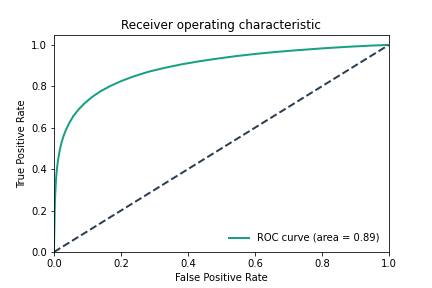

In [ ]:
evaluate(np.array(dists_dd),np.array(labels_dd), dists_dd,thresholds_roc_start= 0.1, thresholds_roc_end=1.5,thresholds_roc_step=0.01, diagonal_excl=True)
Image.open('/content/roc.png')

#### MTCNN for LFW dataset

In [ ]:
data_dir = '/content/lfw'

MTCNN importing

In [ ]:
%cd '/content/InsightFace_Pytorch'
from mtcnn import MTCNN
mtcnn = MTCNN()
%cd ..

/content/InsightFace_Pytorch
/content


In [ ]:
def collate_fn(x):
    return x[0]

workers = 0 if os.name == 'nt' else 4

dataset = datasets.ImageFolder(data_dir)
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

Aligned data preparation.

In [ ]:
aligned_lfw = []
names_lfw = []
time_ = []
trans = transforms.ToTensor()

for x, y in tqdm(loader):

  start_ = time.time()

  try:
    _, landmarks = mtcnn.detect_faces(x)
  except:
    landmarks = []

  if len(landmarks) != 0:
    x_aligned = mtcnn.align(x)

    diff = time.time() - start_
    time_.append(diff)

    aligned_lfw.append(trans(x_aligned))
    names_lfw.append(dataset.idx_to_class[y])

# Total time
total_time = np.array(time_).sum()
# Mean time
mean_diff = np.array(time_).mean()
# Frames per second 
fps = 1 / mean_diff

print("\nTotal time(sec): {:.2f}, Average(sec):{:.2f}, fps:{:.2f}\n".format(total_time, mean_diff, fps))

  0%|          | 0/13233 [00:00<?, ?it/s]/content/InsightFace_Pytorch/mtcnn_pytorch/src/matlab_cp2tform.py:90: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  r, _, _, _ = lstsq(X, U)
100%|██████████| 13233/13233 [10:42<00:00, 20.58it/s]


Total time(sec): 614.10, Average(sec):0.05, fps:21.27



Number of photos after MTCNN application.

In [ ]:
len(names_lfw)

13059

#### Model validation results on LWE dataset

Calculating elements for evaluation metrices calculation.

In [ ]:
labels_lfw = [[e2==e1 for e2 in names_lfw] for e1 in tqdm(names_lfw)]

100%|██████████| 13059/13059 [00:09<00:00, 1444.51it/s]


In [ ]:
len(labels_lfw)

13059

In [ ]:
aligned_lfw = torch.stack(tuple(aligned_lfw)).to(device)

In [ ]:
dataset = aligned_lfw.clone()
batch_size = 1

In [ ]:
data_loader = DataLoader(
    dataset,
    batch_size=batch_size
)

In [ ]:
data_loader.dataset.size()

torch.Size([13059, 3, 112, 112])

Embedding calculation.

In [ ]:
time_ = []

mobilefacenet_A.to(device).eval()

output_embeddings = []

for i, image in tqdm(enumerate(data_loader)):
  start_ = time.time()

  output = mobilefacenet_A(image.to(device))

  diff = time.time() - start_
  time_.append(diff)

  norm_output = normalize(np.array(output[0].cpu()).reshape(1,-1), norm='l2', axis=1)
  output_embeddings.append(np.array(norm_output))

# Total time
total_time = np.array(time_).sum()
# Mean time
mean_diff = np.array(time_).mean()
# Frames per second 
fps = 1 / mean_diff

print("\nTotal time(sec): {:.2f}, Average(sec):{:.2f}, fps:{:.2f}\n".format(total_time, mean_diff, fps))

13059it [01:17, 169.51it/s]


Total time(sec): 72.62, Average(sec):0.01, fps:179.83



In [ ]:
len(output_embeddings)

13059

In [ ]:
embeddings = torch.from_numpy(np.array(output_embeddings)).squeeze(1)

In [ ]:
dists_lfw = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in tqdm(embeddings)]

100%|██████████| 13059/13059 [43:00<00:00,  5.06it/s]


In [ ]:
len(dists_lfw),len(dists_lfw[0]),len(labels_lfw),len(labels_lfw[0])

(13059, 13059, 13059, 13059)

the best accuracy: 0.999363926886672 True Positive rate: 0.8305811798513213 False Positive rate: 0.00015940562086354587 threshold: 1.04


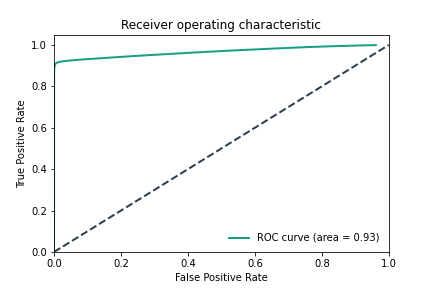

In [ ]:
evaluate(np.array(dists_lfw),np.array(labels_lfw), dists_lfw, thresholds_roc_start= 0.01, thresholds_roc_end=1.5, thresholds_roc_step=0.01, diagonal_excl=True)
Image.open('/content/roc.png')

### MobileFaceNet-B

Downloading needed repositories.

In [ ]:
!git clone https://github.com/TreB1eN/InsightFace_Pytorch.git

fatal: destination path 'InsightFace_Pytorch' already exists and is not an empty directory.


Model downlading.

In [ ]:
%cd '/content/InsightFace_Pytorch'
from model import MobileFaceNet
%cd ..

/content/InsightFace_Pytorch
/content


In [ ]:
url = 'https://drive.google.com/uc?export=download&id=1NofDYM1xnQUopTNMx4Qsieb_XUJ208mo'
output = 'model_mobilefacenet_arcface.pth'
gdown.download(url, output, False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1NofDYM1xnQUopTNMx4Qsieb_XUJ208mo
To: /content/model_mobilefacenet_arcface.pth
4.94MB [00:00, 170MB/s]


'model_mobilefacenet_arcface.pth'

In [ ]:
resize = 112
train_data_dir = '/content/vgg2_train'
valid_data_dir = '/content/vgg2_test'

Number of identities in training and validation set.

In [ ]:
import os

def fcount(path):
    count1 = 0
    for root, dirs, files in os.walk(path):
            count1 += len(dirs)

    return print(count1)

fcount(train_data_dir) 
fcount(valid_data_dir) 

1644
411


In [ ]:
img_transformed = Compose([Resize([resize,resize]), ToTensor()])

train_data = datasets.ImageFolder(train_data_dir, transform=img_transformed)
train_data.idx_to_class = {i:c for c, i in train_data.class_to_idx.items()}

valid_data = datasets.ImageFolder(valid_data_dir, transform=img_transformed)
valid_data.idx_to_class = {i:c for c, i in valid_data.class_to_idx.items()}

Model definition.

In [ ]:
url = 'https://drive.google.com/uc?export=download&id=1NofDYM1xnQUopTNMx4Qsieb_XUJ208mo'
output = 'model_mobilefacenet_arcface.pth'
gdown.download(url, output, False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1NofDYM1xnQUopTNMx4Qsieb_XUJ208mo
To: /content/model_mobilefacenet_arcface.pth
4.94MB [00:00, 106MB/s]


'model_mobilefacenet_arcface.pth'

In [ ]:
mobilefacenet = MobileFaceNet(embedding_size=512)
mobilefacenet.load_state_dict(torch.load('model_mobilefacenet_arcface.pth'))

<All keys matched successfully>

In [ ]:
for i, (name, params) in enumerate(mobilefacenet.named_parameters()):
  print(i, name)

0 conv1.conv.weight
1 conv1.bn.weight
2 conv1.bn.bias
3 conv1.prelu.weight
4 conv2_dw.conv.weight
5 conv2_dw.bn.weight
6 conv2_dw.bn.bias
7 conv2_dw.prelu.weight
8 conv_23.conv.conv.weight
9 conv_23.conv.bn.weight
10 conv_23.conv.bn.bias
11 conv_23.conv.prelu.weight
12 conv_23.conv_dw.conv.weight
13 conv_23.conv_dw.bn.weight
14 conv_23.conv_dw.bn.bias
15 conv_23.conv_dw.prelu.weight
16 conv_23.project.conv.weight
17 conv_23.project.bn.weight
18 conv_23.project.bn.bias
19 conv_3.model.0.conv.conv.weight
20 conv_3.model.0.conv.bn.weight
21 conv_3.model.0.conv.bn.bias
22 conv_3.model.0.conv.prelu.weight
23 conv_3.model.0.conv_dw.conv.weight
24 conv_3.model.0.conv_dw.bn.weight
25 conv_3.model.0.conv_dw.bn.bias
26 conv_3.model.0.conv_dw.prelu.weight
27 conv_3.model.0.project.conv.weight
28 conv_3.model.0.project.bn.weight
29 conv_3.model.0.project.bn.bias
30 conv_3.model.1.conv.conv.weight
31 conv_3.model.1.conv.bn.weight
32 conv_3.model.1.conv.bn.bias
33 conv_3.model.1.conv.prelu.weight
34

In [ ]:
for i, (name, params) in enumerate(mobilefacenet.named_parameters()):
  params.requires_grad = True

for i, (name, params) in enumerate(mobilefacenet.named_parameters()):
  if i >= 173:
    params.requires_grad = True
  else:
    params.requires_grad = False

for name, params in mobilefacenet.named_parameters():
  if params.requires_grad == True:
    print(name)

conv_6_sep.conv.weight
conv_6_sep.bn.weight
conv_6_sep.bn.bias
conv_6_sep.prelu.weight
conv_6_dw.conv.weight
conv_6_dw.bn.weight
conv_6_dw.bn.bias
linear.weight
bn.weight
bn.bias


In [ ]:
mobilefacenet

MobileFaceNet(
  (conv1): Conv_block(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=64)
  )
  (conv2_dw): Conv_block(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=64)
  )
  (conv_23): Depth_Wise(
    (conv): Conv_block(
      (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=128)
    )
    (conv_dw): Conv_block(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=128, bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [ ]:
class MobileFaceNet(nn.Module):
    def __init__(self, net, last_layer_size, embedding_size):
        super().__init__()
        self.embedding_size = embedding_size
        self.last_layer_size = last_layer_size
        
        self.core = net
        
    def forward(self, x):
        x = self.core(x)
        #x = x.view(x.shape[0],-1)
        #x = torch.nn.functional.normalize(x, p=2, dim=-1)
        return x

In [ ]:
checkpoint_callback = set_checkpoint_callback('../content/gdrive/My Drive/DNN/checkpoints/', save_top_k=1, net_name='MobileFaceNetB')

In [ ]:
tb_logger = pl.loggers.TensorBoardLogger('../content/gdrive/My Drive/DNN/deep_metric_logs/', name='MobileFaceNetB')

In [ ]:
trainer = pl.Trainer(early_stop_callback=early_stop_callback, checkpoint_callback=checkpoint_callback, max_epochs=20, logger=tb_logger, gpus=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [ ]:
mobilefacenet_B = DeepMetricLearnerB(embedding_size=512, myclass=MobileFaceNet, net=mobilefacenet, embedding_size_net=512, batch_size=1024)

Training model phase.

In [ ]:
trainer.fit(mobilefacenet_B)

Model loading from a checkpoint.

In [ ]:
#mobilefacenet_B.load_from_checkpoint('/content/gdrive/My Drive/DNN_9/MobileFaceNetVBMobileFaceNetVB_ckpt_epoch_11.ckpt', myclass=MobileFaceNet, net=mobilefacenet)

DeepMetricLearnerB(
  (net): MobileFaceNet(
    (core): MobileFaceNet(
      (conv1): Conv_block(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (prelu): PReLU(num_parameters=64)
      )
      (conv2_dw): Conv_block(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (prelu): PReLU(num_parameters=64)
      )
      (conv_23): Depth_Wise(
        (conv): Conv_block(
          (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (prelu): PReLU(num_parameters=128)
        )
        (conv_dw): Conv_block(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2,

In [ ]:
for names, params in mobilefacenet_B.named_parameters():
  params.requires_grad = False

for names, params in mobilefacenet_B.named_parameters():
  if params.requires_grad == True:
    print(names)

#### MTCNN for Personal Photos

In [ ]:
data_dir = '/content/Faces_Folder'

Importing MTCNN.

In [ ]:
%cd '/content/InsightFace_Pytorch'
from mtcnn import MTCNN
mtcnn = MTCNN()
%cd ..

/content/InsightFace_Pytorch
/content


In [ ]:
def collate_fn(x):
    return x[0]

workers = 0 if os.name == 'nt' else 4

dataset = datasets.ImageFolder(data_dir)
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

In [ ]:
aligned_dd = []
names_dd = []
time_ = []

trans = transforms.ToTensor()

for x, y in tqdm(loader):

  start_ = time.time()

  try:
    _, landmarks = mtcnn.detect_faces(x)
  except:
    landmarks = []

  if len(landmarks) != 0:
    x_aligned = mtcnn.align(x)

    diff = time.time() - start_
    time_.append(diff)

    aligned_dd.append(trans(x_aligned))
    names_dd.append(dataset.idx_to_class[y])

# Total time
total_time = np.array(time_).sum()
# Mean time
mean_diff = np.array(time_).mean()
# Frames per second 
fps = 1 / mean_diff

print("\nTotal time(sec): {:.2f}, Average(sec):{:.2f}, fps:{:.2f}\n".format(total_time, mean_diff, fps))


  0%|          | 0/1205 [00:00<?, ?it/s]/content/InsightFace_Pytorch/mtcnn_pytorch/src/matlab_cp2tform.py:90: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  r, _, _, _ = lstsq(X, U)

100%|██████████| 1205/1205 [04:53<00:00,  4.10it/s]


Total time(sec): 255.87, Average(sec):0.26, fps:3.87



Number of aligned photos after MTCNN.

In [ ]:
len(names_dd)

991

#### Model validation results on Personal Photos

Calculating elements needed for evaluation metrices calculation.

In [ ]:
labels_dd = [[e2==e1 for e2 in names_dd] for e1 in tqdm(names_dd)]


100%|██████████| 991/991 [00:00<00:00, 18560.28it/s]


In [ ]:
aligned_dd = torch.stack(tuple(aligned_dd)).to(device)

In [ ]:
dataset = aligned_dd.clone()
batch_size = 1

In [ ]:
data_loader = DataLoader(
    dataset,
    batch_size=batch_size
)

In [ ]:
data_loader.dataset.size()

torch.Size([991, 3, 112, 112])

In [ ]:
time_ = []

mobilefacenet_B.to(device).eval()

output_embeddings = []

for i, image in tqdm(enumerate(data_loader)):
  start_ = time.time()

  output = mobilefacenet_B(image.to(device))

  diff = time.time() - start_
  time_.append(diff)

  norm_output = normalize(np.array(output[0].cpu()).reshape(1,-1), norm='l2', axis=1)
  output_embeddings.append(np.array(norm_output))

# Total time
total_time = np.array(time_).sum()
# Mean time
mean_diff = np.array(time_).mean()
# Frames per second 
fps = 1 / mean_diff

print("\nTotal time(sec): {:.2f}, Average(sec):{:.2f}, fps:{:.2f}\n".format(total_time, mean_diff, fps))


0it [00:00, ?it/s]
16it [00:00, 158.41it/s]
31it [00:00, 154.72it/s]
47it [00:00, 156.26it/s]
64it [00:00, 159.99it/s]
81it [00:00, 161.96it/s]
99it [00:00, 164.64it/s]
116it [00:00, 165.80it/s]
133it [00:00, 166.97it/s]
150it [00:00, 166.78it/s]
167it [00:01, 167.17it/s]
185it [00:01, 168.28it/s]
202it [00:01, 165.80it/s]
219it [00:01, 166.91it/s]
236it [00:01, 167.34it/s]
254it [00:01, 168.52it/s]
272it [00:01, 169.62it/s]
289it [00:01, 169.14it/s]
306it [00:01, 168.67it/s]
323it [00:01, 168.68it/s]
341it [00:02, 169.48it/s]
359it [00:02, 170.27it/s]
377it [00:02, 164.83it/s]
394it [00:02, 161.54it/s]
411it [00:02, 162.01it/s]
428it [00:02, 162.42it/s]
445it [00:02, 162.49it/s]
462it [00:02, 163.91it/s]
479it [00:02, 164.84it/s]
496it [00:02, 166.23it/s]
513it [00:03, 166.64it/s]
530it [00:03, 165.17it/s]
547it [00:03, 163.97it/s]
564it [00:03, 163.63it/s]
581it [00:03, 161.83it/s]
599it [00:03, 164.49it/s]
616it [00:03, 163.46it/s]
633it [00:03, 164.53it/s]
650it [00:03, 161.36it/s


Total time(sec): 5.58, Average(sec):0.01, fps:177.51



In [ ]:
len(output_embeddings)

991

In [ ]:
embeddings = torch.from_numpy(np.array(output_embeddings)).squeeze(1)

In [ ]:
dists_dd = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in tqdm(embeddings)]


100%|██████████| 991/991 [00:15<00:00, 62.73it/s]


In [ ]:
len(dists_dd),len(dists_dd[0]),len(labels_dd),len(labels_dd[0])

(991, 991, 991, 991)

the best accuracy: 0.8397027795615081 True Positive rate: 0.6562545337563788 False Positive rate: 0.07270219148705469 threshold: 1.1799999999999995


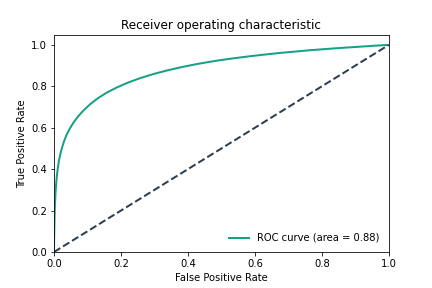

In [ ]:
evaluate(np.array(dists_dd),np.array(labels_dd), dists_dd,thresholds_roc_start= 0.1, thresholds_roc_end=1.5,thresholds_roc_step=0.01, diagonal_excl=True)
Image.open('/content/roc.png')

#### MTCNN for LFW dataset

In [ ]:
data_dir = '/content/lfw'

MTCNN importing

In [ ]:
%cd '/content/InsightFace_Pytorch'
from mtcnn import MTCNN
mtcnn = MTCNN()
%cd ..

/content/InsightFace_Pytorch
/content


In [ ]:
def collate_fn(x):
    return x[0]

workers = 0 if os.name == 'nt' else 4

dataset = datasets.ImageFolder(data_dir)
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

Aligned data preparation.

In [ ]:
aligned_lfw = []
names_lfw = []
time_ = []
trans = transforms.ToTensor()

for x, y in tqdm(loader):

  start_ = time.time()

  try:
    _, landmarks = mtcnn.detect_faces(x)
  except:
    landmarks = []

  if len(landmarks) != 0:
    x_aligned = mtcnn.align(x)

    diff = time.time() - start_
    time_.append(diff)

    aligned_lfw.append(trans(x_aligned))
    names_lfw.append(dataset.idx_to_class[y])

# Total time
total_time = np.array(time_).sum()
# Mean time
mean_diff = np.array(time_).mean()
# Frames per second 
fps = 1 / mean_diff

print("\nTotal time(sec): {:.2f}, Average(sec):{:.2f}, fps:{:.2f}\n".format(total_time, mean_diff, fps))


  0%|          | 0/13233 [00:00<?, ?it/s]/content/InsightFace_Pytorch/mtcnn_pytorch/src/matlab_cp2tform.py:90: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  r, _, _, _ = lstsq(X, U)

100%|██████████| 13233/13233 [10:30<00:00, 20.99it/s]


Total time(sec): 581.01, Average(sec):0.04, fps:22.48



Number of photos after MTCNN application.

In [ ]:
len(names_lfw)

13059

#### Model validation results on LWE dataset

Calculating elements for evaluation metrices calculation.

In [ ]:
labels_lfw = [[e2==e1 for e2 in names_lfw] for e1 in tqdm(names_lfw)]


100%|██████████| 13059/13059 [00:09<00:00, 1393.92it/s]


In [ ]:
len(labels_lfw)

13059

In [ ]:
aligned_lfw = torch.stack(tuple(aligned_lfw)).to(device)

In [ ]:
dataset = aligned_lfw.clone()
batch_size = 1

In [ ]:
data_loader = DataLoader(
    dataset,
    batch_size=batch_size
)

In [ ]:
data_loader.dataset.size()

torch.Size([13059, 3, 112, 112])

Embedding calculation.

In [ ]:
time_ = []

mobilefacenet_B.to(device).eval()

output_embeddings = []

for i, image in tqdm(enumerate(data_loader)):
  start_ = time.time()

  output = mobilefacenet_B(image.to(device))

  diff = time.time() - start_
  time_.append(diff)

  norm_output = normalize(np.array(output[0].cpu()).reshape(1,-1), norm='l2', axis=1)
  output_embeddings.append(np.array(norm_output))

# Total time
total_time = np.array(time_).sum()
# Mean time
mean_diff = np.array(time_).mean()
# Frames per second 
fps = 1 / mean_diff

print("\nTotal time(sec): {:.2f}, Average(sec):{:.2f}, fps:{:.2f}\n".format(total_time, mean_diff, fps))


0it [00:00, ?it/s]
17it [00:00, 167.10it/s]
34it [00:00, 167.41it/s]
51it [00:00, 167.66it/s]
68it [00:00, 168.33it/s]
85it [00:00, 166.31it/s]
102it [00:00, 165.52it/s]
118it [00:00, 163.59it/s]
135it [00:00, 163.62it/s]
152it [00:00, 164.19it/s]
169it [00:01, 163.92it/s]
186it [00:01, 164.13it/s]
203it [00:01, 164.24it/s]
220it [00:01, 163.92it/s]
237it [00:01, 164.50it/s]
254it [00:01, 165.92it/s]
271it [00:01, 164.26it/s]
288it [00:01, 163.39it/s]
306it [00:01, 165.64it/s]
323it [00:01, 166.49it/s]
340it [00:02, 167.23it/s]
357it [00:02, 167.55it/s]
374it [00:02, 166.80it/s]
391it [00:02, 167.60it/s]
408it [00:02, 167.49it/s]
425it [00:02, 166.34it/s]
442it [00:02, 163.39it/s]
459it [00:02, 163.98it/s]
476it [00:02, 165.66it/s]
493it [00:02, 166.26it/s]
510it [00:03, 165.56it/s]
527it [00:03, 161.86it/s]
544it [00:03, 162.77it/s]
561it [00:03, 164.42it/s]
578it [00:03, 163.91it/s]
595it [00:03, 163.98it/s]
612it [00:03, 161.89it/s]
630it [00:03, 164.46it/s]
647it [00:03, 164.97it/


Total time(sec): 74.15, Average(sec):0.01, fps:176.11



In [ ]:
len(output_embeddings)

13059

In [ ]:
embeddings = torch.from_numpy(np.array(output_embeddings)).squeeze(1)

In [ ]:
dists_lfw = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in tqdm(embeddings)]

Streaming output truncated to the last 5000 lines.
100%|██████████| 13059/13059 [44:30<00:00,  4.89it/s]


In [ ]:
len(dists_lfw),len(dists_lfw[0]),len(labels_lfw),len(labels_lfw[0])

(13059, 13059, 13059, 13059)

the best accuracy: 0.999335907439698 True Positive rate: 0.8243175145242905 False Positive rate: 0.0001698146797039678 threshold: 1.01


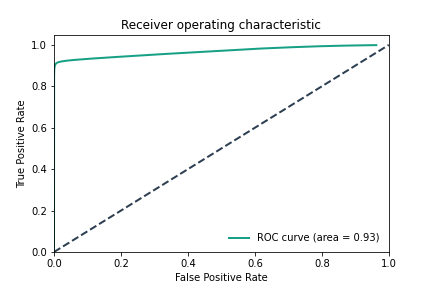

In [ ]:
evaluate(np.array(dists_lfw),np.array(labels_lfw), dists_lfw, thresholds_roc_start= 0.01, thresholds_roc_end=1.5, thresholds_roc_step=0.01, diagonal_excl=True)
Image.open('/content/roc.png')

### MobileFaceNet-C

Downloading needed repositories.

In [11]:
!git clone https://github.com/TreB1eN/InsightFace_Pytorch.git

fatal: destination path 'InsightFace_Pytorch' already exists and is not an empty directory.


Model downlading.

In [12]:
%cd '/content/InsightFace_Pytorch'
from model import MobileFaceNet
%cd ..

/content/InsightFace_Pytorch
/content


In [13]:
url = 'https://drive.google.com/uc?export=download&id=1NofDYM1xnQUopTNMx4Qsieb_XUJ208mo'
output = 'model_mobilefacenet_arcface.pth'
gdown.download(url, output, False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1NofDYM1xnQUopTNMx4Qsieb_XUJ208mo
To: /content/model_mobilefacenet_arcface.pth
4.94MB [00:00, 80.7MB/s]


'model_mobilefacenet_arcface.pth'

In [14]:
resize = 112
train_data_dir = '/content/vgg2_train'
valid_data_dir = '/content/vgg2_test'

Number of identities in training and validation set.

In [15]:
import os

def fcount(path):
    count1 = 0
    for root, dirs, files in os.walk(path):
            count1 += len(dirs)

    return print(count1)

fcount(train_data_dir) 
fcount(valid_data_dir) 

1644
411


In [16]:
img_transformed = Compose([Resize([resize,resize]), ToTensor()])

train_data = datasets.ImageFolder(train_data_dir, transform=img_transformed)
train_data.idx_to_class = {i:c for c, i in train_data.class_to_idx.items()}

valid_data = datasets.ImageFolder(valid_data_dir, transform=img_transformed)
valid_data.idx_to_class = {i:c for c, i in valid_data.class_to_idx.items()}

In [17]:
url = 'https://drive.google.com/uc?export=download&id=1NofDYM1xnQUopTNMx4Qsieb_XUJ208mo'
output = 'model_mobilefacenet_arcface.pth'
gdown.download(url, output, False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1NofDYM1xnQUopTNMx4Qsieb_XUJ208mo
To: /content/model_mobilefacenet_arcface.pth
4.94MB [00:00, 306MB/s]


'model_mobilefacenet_arcface.pth'

In [18]:
mobilefacenet = MobileFaceNet(embedding_size=512)
mobilefacenet.load_state_dict(torch.load('model_mobilefacenet_arcface.pth'))

<All keys matched successfully>

In [19]:
for i, (name, params) in enumerate(mobilefacenet.named_parameters()):
  print(i, name)

0 conv1.conv.weight
1 conv1.bn.weight
2 conv1.bn.bias
3 conv1.prelu.weight
4 conv2_dw.conv.weight
5 conv2_dw.bn.weight
6 conv2_dw.bn.bias
7 conv2_dw.prelu.weight
8 conv_23.conv.conv.weight
9 conv_23.conv.bn.weight
10 conv_23.conv.bn.bias
11 conv_23.conv.prelu.weight
12 conv_23.conv_dw.conv.weight
13 conv_23.conv_dw.bn.weight
14 conv_23.conv_dw.bn.bias
15 conv_23.conv_dw.prelu.weight
16 conv_23.project.conv.weight
17 conv_23.project.bn.weight
18 conv_23.project.bn.bias
19 conv_3.model.0.conv.conv.weight
20 conv_3.model.0.conv.bn.weight
21 conv_3.model.0.conv.bn.bias
22 conv_3.model.0.conv.prelu.weight
23 conv_3.model.0.conv_dw.conv.weight
24 conv_3.model.0.conv_dw.bn.weight
25 conv_3.model.0.conv_dw.bn.bias
26 conv_3.model.0.conv_dw.prelu.weight
27 conv_3.model.0.project.conv.weight
28 conv_3.model.0.project.bn.weight
29 conv_3.model.0.project.bn.bias
30 conv_3.model.1.conv.conv.weight
31 conv_3.model.1.conv.bn.weight
32 conv_3.model.1.conv.bn.bias
33 conv_3.model.1.conv.prelu.weight
34

In [20]:
for i, (name, params) in enumerate(mobilefacenet.named_parameters()):
  params.requires_grad = True

for i, (name, params) in enumerate(mobilefacenet.named_parameters()):
  if i >= 173:
    params.requires_grad = True
  else:
    params.requires_grad = False

for name, params in mobilefacenet.named_parameters():
  if params.requires_grad == True:
    print(name)

conv_6_sep.conv.weight
conv_6_sep.bn.weight
conv_6_sep.bn.bias
conv_6_sep.prelu.weight
conv_6_dw.conv.weight
conv_6_dw.bn.weight
conv_6_dw.bn.bias
linear.weight
bn.weight
bn.bias


In [21]:
mobilefacenet

MobileFaceNet(
  (conv1): Conv_block(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=64)
  )
  (conv2_dw): Conv_block(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=64)
  )
  (conv_23): Depth_Wise(
    (conv): Conv_block(
      (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=128)
    )
    (conv_dw): Conv_block(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=128, bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [22]:
class MobileFaceNet(nn.Module):
    def __init__(self, net, last_layer_size, embedding_size):
        super().__init__()
        self.embedding_size = embedding_size
        self.last_layer_size = last_layer_size
        
        self.core = net
        
    def forward(self, x):
        x = self.core(x)
        #x = x.view(x.shape[0],-1)
        #x = torch.nn.functional.normalize(x, p=2, dim=-1)
        return x

In [23]:
checkpoint_callback = set_checkpoint_callback('../content/gdrive/My Drive/DNN/checkpoints/', save_top_k=1, net_name='MobileFaceNetC')

In [24]:
tb_logger = pl.loggers.TensorBoardLogger('../content/gdrive/My Drive/DNN/deep_metric_logs/', name='MobileFaceNetC')

In [25]:
trainer = pl.Trainer(early_stop_callback=early_stop_callback, checkpoint_callback=checkpoint_callback, max_epochs=20, logger=tb_logger, gpus=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [26]:
mobilefacenet_C = DeepMetricLearnerC(embedding_size=512, myclass=MobileFaceNet, net=mobilefacenet, embedding_size_net=512, batch_size=1024)

Training model phase.

In [ ]:
trainer.fit(mobilefacenet_C)

Model loading from a checkpoint.

In [28]:
mobilefacenet_C.load_from_checkpoint('/content/gdrive/My Drive/DNN_9/MobileFaceNetVDMobileFaceNetC_ckpt_epoch_1.ckpt', myclass=MobileFaceNet, net=mobilefacenet)

DeepMetricLearnerC(
  (net): MobileFaceNet(
    (core): MobileFaceNet(
      (conv1): Conv_block(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (prelu): PReLU(num_parameters=64)
      )
      (conv2_dw): Conv_block(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (prelu): PReLU(num_parameters=64)
      )
      (conv_23): Depth_Wise(
        (conv): Conv_block(
          (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (prelu): PReLU(num_parameters=128)
        )
        (conv_dw): Conv_block(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2,

In [29]:
for names, params in mobilefacenet_C.named_parameters():
  params.requires_grad = False

for names, params in mobilefacenet_C.named_parameters():
  if params.requires_grad == True:
    print(names)

#### MTCNN for Personal Photos

In [30]:
data_dir = '/content/Faces_Folder'

Importing MTCNN.

In [31]:
%cd '/content/InsightFace_Pytorch'
from mtcnn import MTCNN
mtcnn = MTCNN()
%cd ..

/content/InsightFace_Pytorch
/content


In [32]:
def collate_fn(x):
    return x[0]

workers = 0 if os.name == 'nt' else 4

dataset = datasets.ImageFolder(data_dir)
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

In [33]:
aligned_dd = []
names_dd = []
time_ = []

trans = transforms.ToTensor()

for x, y in tqdm(loader):

  start_ = time.time()

  try:
    _, landmarks = mtcnn.detect_faces(x)
  except:
    landmarks = []

  if len(landmarks) != 0:
    x_aligned = mtcnn.align(x)

    diff = time.time() - start_
    time_.append(diff)

    aligned_dd.append(trans(x_aligned))
    names_dd.append(dataset.idx_to_class[y])

# Total time
total_time = np.array(time_).sum()
# Mean time
mean_diff = np.array(time_).mean()
# Frames per second 
fps = 1 / mean_diff

print("\nTotal time(sec): {:.2f}, Average(sec):{:.2f}, fps:{:.2f}\n".format(total_time, mean_diff, fps))

  0%|          | 0/1205 [00:00<?, ?it/s]/content/InsightFace_Pytorch/mtcnn_pytorch/src/matlab_cp2tform.py:90: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  r, _, _, _ = lstsq(X, U)
100%|██████████| 1205/1205 [04:53<00:00,  4.10it/s]


Total time(sec): 257.55, Average(sec):0.26, fps:3.85



Number of aligned photos after MTCNN.

In [34]:
len(names_dd)

991

#### Model validation results on Personal Photos

Calculating elements needed for evaluation metrices calculation.

In [35]:
labels_dd = [[e2==e1 for e2 in names_dd] for e1 in tqdm(names_dd)]

100%|██████████| 991/991 [00:00<00:00, 20646.71it/s]


In [36]:
aligned_dd = torch.stack(tuple(aligned_dd)).to(device)

In [37]:
dataset = aligned_dd.clone()
batch_size = 1

In [38]:
data_loader = DataLoader(
    dataset,
    batch_size=batch_size
)

In [39]:
data_loader.dataset.size()

torch.Size([991, 3, 112, 112])

In [40]:
time_ = []

mobilefacenet_C.to(device).eval()

output_embeddings = []

for i, image in tqdm(enumerate(data_loader)):
  start_ = time.time()

  output = mobilefacenet_C(image.to(device))

  diff = time.time() - start_
  time_.append(diff)

  norm_output = normalize(np.array(output[0].cpu()).reshape(1,-1), norm='l2', axis=1)
  output_embeddings.append(np.array(norm_output))

# Total time
total_time = np.array(time_).sum()
# Mean time
mean_diff = np.array(time_).mean()
# Frames per second 
fps = 1 / mean_diff

print("\nTotal time(sec): {:.2f}, Average(sec):{:.2f}, fps:{:.2f}\n".format(total_time, mean_diff, fps))

991it [00:05, 169.62it/s]


Total time(sec): 5.49, Average(sec):0.01, fps:180.42



In [41]:
len(output_embeddings)

991

In [42]:
embeddings = torch.from_numpy(np.array(output_embeddings)).squeeze(1)

In [43]:
dists_dd = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in tqdm(embeddings)]

100%|██████████| 991/991 [00:15<00:00, 64.61it/s]


In [44]:
len(dists_dd),len(dists_dd[0]),len(labels_dd),len(labels_dd[0])

(991, 991, 991, 991)

the best accuracy: 0.849752825938497 True Positive rate: 0.6561536083969899 False Positive rate: 0.05780513957326844 threshold: 1.1999999999999995


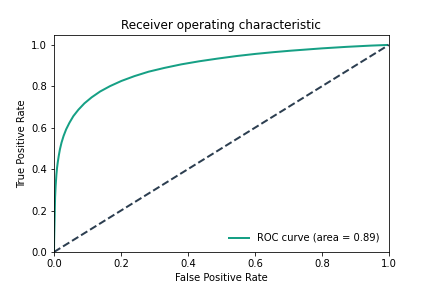

In [45]:
evaluate(np.array(dists_dd),np.array(labels_dd), dists_dd,thresholds_roc_start= 0.1, thresholds_roc_end=1.5,thresholds_roc_step=0.01, diagonal_excl=True)
Image.open('/content/roc.png')

#### MTCNN for LFW dataset

In [61]:
data_dir = '/content/lfw'

MTCNN importing

In [62]:
%cd '/content/InsightFace_Pytorch'
from mtcnn import MTCNN
mtcnn = MTCNN()
%cd ..

/content/InsightFace_Pytorch
/content


In [63]:
def collate_fn(x):
    return x[0]

workers = 0 if os.name == 'nt' else 4

dataset = datasets.ImageFolder(data_dir)
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

Aligned data preparation.

In [64]:
aligned_lfw = []
names_lfw = []
time_ = []
trans = transforms.ToTensor()

for x, y in tqdm(loader):

  start_ = time.time()

  try:
    _, landmarks = mtcnn.detect_faces(x)
  except:
    landmarks = []

  if len(landmarks) != 0:
    x_aligned = mtcnn.align(x)

    diff = time.time() - start_
    time_.append(diff)

    aligned_lfw.append(trans(x_aligned))
    names_lfw.append(dataset.idx_to_class[y])

# Total time
total_time = np.array(time_).sum()
# Mean time
mean_diff = np.array(time_).mean()
# Frames per second 
fps = 1 / mean_diff

print("\nTotal time(sec): {:.2f}, Average(sec):{:.2f}, fps:{:.2f}\n".format(total_time, mean_diff, fps))

  0%|          | 0/13233 [00:00<?, ?it/s]/content/InsightFace_Pytorch/mtcnn_pytorch/src/matlab_cp2tform.py:90: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  r, _, _, _ = lstsq(X, U)
100%|██████████| 13233/13233 [16:23<00:00, 13.45it/s]


Total time(sec): 946.80, Average(sec):0.07, fps:13.79



Number of photos after MTCNN application.

In [65]:
len(names_lfw)

13059

#### Model validation results on LWE dataset

Calculating elements for evaluation metrices calculation.

In [66]:
labels_lfw = [[e2==e1 for e2 in names_lfw] for e1 in tqdm(names_lfw)]

100%|██████████| 13059/13059 [00:10<00:00, 1261.39it/s]


In [67]:
len(labels_lfw)

13059

In [68]:
len(aligned_lfw )

13059

In [69]:
aligned_lfw = torch.stack(tuple(aligned_lfw)).to(device)

In [70]:
dataset = aligned_lfw.clone()
batch_size = 1

In [71]:
data_loader = DataLoader(
    dataset,
    batch_size=batch_size
)

In [72]:
data_loader.dataset.size()

torch.Size([13059, 3, 112, 112])

Embedding calculation.

In [73]:
time_ = []

mobilefacenet_C.to(device).eval()

output_embeddings = []

for i, image in tqdm(enumerate(data_loader)):
  start_ = time.time()

  output = mobilefacenet_C(image.to(device))

  diff = time.time() - start_
  time_.append(diff)

  norm_output = normalize(np.array(output[0].cpu()).reshape(1,-1), norm='l2', axis=1)
  output_embeddings.append(np.array(norm_output))

# Total time
total_time = np.array(time_).sum()
# Mean time
mean_diff = np.array(time_).mean()
# Frames per second 
fps = 1 / mean_diff

print("\nTotal time(sec): {:.2f}, Average(sec):{:.2f}, fps:{:.2f}\n".format(total_time, mean_diff, fps))

13059it [01:16, 169.88it/s]


Total time(sec): 72.16, Average(sec):0.01, fps:180.97



In [74]:
len(output_embeddings)

13059

In [75]:
embeddings = torch.from_numpy(np.array(output_embeddings)).squeeze(1)

In [76]:
dists_lfw = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in tqdm(embeddings)]

100%|██████████| 13059/13059 [42:42<00:00,  5.10it/s]


In [77]:
len(dists_lfw),len(dists_lfw[0]),len(labels_lfw),len(labels_lfw[0])

(13059, 13059, 13059, 13059)

the best accuracy: 0.9993657096225197 True Positive rate: 0.8307144493263644 False Positive rate: 0.0001579942230546751 threshold: 1.04


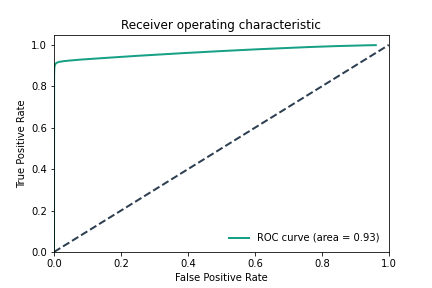

In [78]:
evaluate(np.array(dists_lfw),np.array(labels_lfw), dists_lfw, thresholds_roc_start= 0.01, thresholds_roc_end=1.5, thresholds_roc_step=0.01, diagonal_excl=True)
Image.open('/content/roc.png')